# **Title: Training-Free Long-Context Scaling of Large Language Models**
###Group Members' Names: Bardia Dehbasti and Anthony Valenti
###Group Members' Emails: bardia.dehbasti@torontomu.ca, anthony.valenti@torontomu.ca

# **Introduction**
## Problem Description:
Large Language Models (LLMs) are currently going through a great period of growth, achieving stronger and more impressive results seemingly every month. However, the effectiveness of currently available models decreases as the number of input tokens, or context length, increases. Popular open source LLMs such as LLama2 7B support a maximum context length of 4096 tokens, without any fine-tuning. Presented in this study is an implementation of the Dual Chunk Attention algorithm, which enables LLama2 7B to handle a maximum context length of more than 32k tokens, requiring no additional training. The proposed method increases the context length by 8x the orginal tokens.

## Context of the Problem:
With the rise in popularity of LLMs, consumers and businesses alike have been exploring a wide variety of use cases. Specific use cases, such as interacting with large amounts of documents, text, code, or extended conversations, are limited by the maximum context length of the model. One solution to combat this problem is to fine-tune a pre-trained model on longer sequences of tokens. However, this creates a new problem in both access to sufficient training data and the associated time/cost constraints of fine-tuning a model. The proposed Dual Chunk Attention algorithm solves both of these problems by achieving a longer context length while avoiding the necessary data and costs associated with fine-tuning.

## Limitations of Past Approaches:

In similar past approaches to challenge language models beyond short-context, Pang et al, 2022 [2], in his research paper the authors created a QuALITY dataset to challenge language models on long-document comprehension, using the input dataset of English passages of 2k to 8k tokens. They created questions that needed understanding of the whole document to answer, however they found their model to be ineffective in processing long texts and in turn, thier model resulted in poor performance.

## Solution:
In this proposed solution, Dual Chunk Attention (DCA) is introduced to overcome large language model incapabilites to to process long context, without needing additional training. With this approach limitatoins of input tokens of long contexts exceeding pre-training lengths is overcomed. This is achieved by dividing the context into three parts, namely intra-chunk, inter-chunk, and successive chunk attention, which allows LLMs to manage longer sequences of text. This method does not require any additional fine-tuning or training which shows effeciency of this method.


# **Background**

| Reference |Explanation |  Dataset/Input |Weakness
| --- | --- | --- | --- |
| An et al. [1] | Proposed Dual Chunk Attention (DCA), which enables LLMs to support context windows of more than 8x the training length without fine-tuning|  book corpus dataset PG19, NarrativeQA, QMSum, and more| 32K context window on LLama2 7B only achievable with 2xA100 GPUs |
| Pang et al. [2] |	Developed a multiple-choice QA dataset with passages up to 8k tokens to challenge long-context language models  | 	QuALITY dataset with English passages from 2k to 8k tokens |	Baseline models performed poorly, highlighting difficulty in processing long texts effectively |

# **Methodology**

- Intra-chunk attention is used to seperate input suequnces into smaller chunks
  - Intra-chunk attention will assign attention for tokens within the same chunks
  - Intra-chunk works by seperating position indices for queries and keys according to the formula $$P_qIntra = P_k =[0,1,...,l−1] mod s $$ where s is the tokens in each chunk
  - Position matrix M for intra-chunk is then defined as $$M[i][j]=P_qIntra[i]-P_k[j]$$
- Inter-chunk attention is used to assign attention between different chunks
  - The indices are initially set as c-1, where c is the maximum context length LLamma2 was trained on
  - For different chunks attention is then assigned using the matrix M according to the formula $$M[i][j]=P_qIntra[i]-P_k[j]=c-1-P_k[j] ≥ c-s.$$
- A succesive attention calculation is used to preserve attention between neighboring tokens (which have a high correlation in predicting the next token)
  - The equation for succesive attention is $$P_qSucc =[s,s+1,...,s+w−1,c−1,...,c−1], w=c-s$$
- This results in the final relative position matrix M $$
M[i][j] =
\begin{cases}
P_qIntra[i]-P_k[j], & \text{if } [i/s] -[j/s] = 0\\
P_qSucc[i]-P_k[j], & \text{if } [i/s] -[j/s] = 1\\
P_qInter[i]-P_k[j], & \text{if } [i/s] -[j/s] > 1\\
\end{cases}
$$

- Inner product of queries and keys q,k are calculated as
$$
q_i^Tk_j =
\begin{cases}
f(q,P_qIntra[i])^Tf(k,P_k[j]), & \text{if } [i/s] -[j/s] = 0\\
f(q,P_qSucc[i])^Tf(k,P_k[j]), & \text{if } [i/s] -[j/s] = 1\\
f(q,P_qInter[i])^Tf(k,P_k[j]), & \text{if } [i/s] -[j/s] > 1\\
\end{cases}
$$

- Inner product calculations are normalized using softmax and dimensions of LLama2 hidden states d

$$p_i=softmax([\frac{q_i^Tk_0}{\sqrt{d}},\frac{q_i^Tk_1}{\sqrt{d}},...\frac{q_i^Tk_i}{\sqrt{d}} ])$$

- Utilizing this algorithm with LLama2 7B allows us to achieve a context length of 16K tokens on an A100 GPU with 40GB of memory.

- The effectivness of DCA will be tested by uploading a large paper as context to "chat" with the PDF.

- Passkey retrieval is also used to test if LLama2 can identify a provided passkey surrounded by 16K tokens of random text.





## Perplexity Results of different models VS LLama2 with DCA (CHUNKLLAMA2)

Results of perplexity from PG19 validation dataset, where lower score means better performance. When evaluating on a 16k context-length, Llama2-7B with DCA (ChunkLlama2) performs better or equal to comparable fine-tuned models.

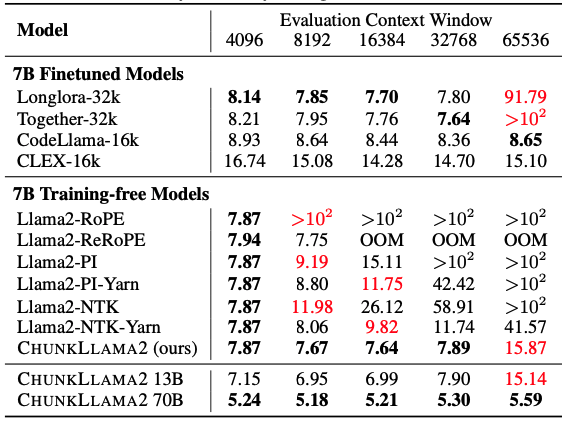

# **Implementation**

## Imports

In [ ]:
!pip install transformers==4.37.0
!pip install torch>=2.0.0
!pip install deepspeed==0.14.0
!pip install sentencepiece>=0.1.99
!pip install tokenizers>=0.14.0
!pip install accelerate>=0.23.0
!pip install flash-attn>=2.5.0 --no-build-isolation
!pip install PyMuPDF

## Dual Chunk Attention Implementation

- This code modifies the LLama2 architecture to seperate large input sequences into smaller chunks, according to the algorithm for DCA described above.


- In the code below, the inner product (dot product) is done using cosine similarity

In [ ]:
from typing import List, Optional, Tuple

from torch import nn
import math
from transformers.models.llama.modeling_llama import rotate_half, repeat_kv
import torch
import transformers
from flash_attn.flash_attn_interface import flash_attn_qkvpacked_func, flash_attn_func
from transformers.cache_utils import Cache

import math


def get_mscale(scale=1):
    if scale <= 1:
        return 1.0
    return 0.1 * math.log(scale) + 1.0


class ChunkLlamaRotaryEmbedding(nn.Module):
    def __init__(self, dim, max_position_embeddings=4096, base=10000, scaling_factor=1.0, device=None):
        super().__init__()

        self.max_seq_len = max_position_embeddings
        self.dim = dim
        self.scaling_factor = scaling_factor
        self.max_position_embeddings = max_position_embeddings
        self.base = base


        self._set_cos_sin_cache(
            seq_len=self.max_seq_len,
            device=device, dtype=torch.float32
        )

    def _set_cos_sin_cache(self, seq_len, device, dtype):
        scale = seq_len / self.max_position_embeddings
        mscale = get_mscale(scale)

        inv_freq = 1.0 / (self.base ** (torch.arange(0, self.dim, 2).float().to(device) / self.dim))
        self.register_buffer("inv_freq", inv_freq, persistent=False)

        chunk_len = chunk_size - local_window
        q_t = torch.arange(chunk_len, device=device, dtype=self.inv_freq.dtype) / self.scaling_factor
        qc_t = (torch.arange(chunk_len, device=device, dtype=self.inv_freq.dtype) + chunk_len).clamp(
            max=chunk_size) / self.scaling_factor
        k_t = (torch.arange(seq_len + MAX_NEW_TOKENS, device=device,
                            dtype=self.inv_freq.dtype) % chunk_len) / self.scaling_factor

        q_freqs = torch.outer(q_t, self.inv_freq)  # seq_len x dim/2
        qc_freqs = torch.outer(qc_t, self.inv_freq)
        k_freqs = torch.outer(k_t, self.inv_freq)  # seq_len x dim/2

        q_emb = torch.cat((q_freqs, q_freqs), dim=-1)  # seq_len x dim
        qc_emb = torch.cat((qc_freqs, qc_freqs), dim=-1)
        k_emb = torch.cat((k_freqs, k_freqs), dim=-1)  # seq_len x dim
        self.register_buffer("q_cos_cached", q_emb.cos().to(dtype) * mscale, persistent=False)
        self.register_buffer("q_sin_cached", q_emb.sin().to(dtype) * mscale, persistent=False)
        self.register_buffer("qc_cos_cached", qc_emb.cos().to(dtype) * mscale, persistent=False)
        self.register_buffer("qc_sin_cached", qc_emb.sin().to(dtype) * mscale, persistent=False)
        self.register_buffer("k_cos_cached", k_emb.cos().to(dtype) * mscale, persistent=False)
        self.register_buffer("k_sin_cached", k_emb.sin().to(dtype) * mscale, persistent=False)

    def forward(self, x, seq_len=None):
        # x: [bs, num_attention_heads, seq_len, head_size]
        # no token will exceed chunk_size
        # chunk1_q,
        if seq_len > self.max_seq_len:
            self._set_cos_sin_cache(seq_len=seq_len, device=self.inv_freq.device, dtype=torch.float32)
            self.max_seq_len = seq_len
        return (
            self.q_cos_cached[:seq_len].to(dtype=x.dtype),
            self.q_sin_cached[:seq_len].to(dtype=x.dtype),
            self.qc_cos_cached[:seq_len].to(dtype=x.dtype),
            self.qc_sin_cached[:seq_len].to(dtype=x.dtype),
            self.k_cos_cached[:seq_len].to(dtype=x.dtype),
            self.k_sin_cached[:seq_len].to(dtype=x.dtype),
        )


def apply_rotary_pos_emb(x, cos, sin, position_ids):
    # The first two dimensions of cos and sin are always 1, so we can `squeeze` them.
    cos = cos.squeeze(1).squeeze(0)  # [seq_len, dim]
    sin = sin.squeeze(1).squeeze(0)  # [seq_len, dim]
    cos = cos[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    sin = sin[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    x_emb = (x * cos) + (rotate_half(x) * sin)
    return x_emb


def merge_attn_outputs(flash_results):
    attn_outputs_all = [flash_results[0][0]]
    flash_results = flash_results[1:]
    for flash_per_chunk in flash_results:
        attn_outputs = torch.stack([flash_attn_output[0] for flash_attn_output in flash_per_chunk])
        logits = torch.stack([flash_attn_output[1] for flash_attn_output in flash_per_chunk])
        max_logits = torch.max(logits, dim=0).values
        stable_logits = logits - max_logits.unsqueeze(0)

        lse_s = torch.exp(stable_logits).detach()
        lse_sum = torch.sum(lse_s, dim=0)
        lse_s /= lse_sum
        attn_outputs *= lse_s.unsqueeze(-1)
        attn_outputs_all.append(attn_outputs.sum(dim=0))
    return torch.cat(attn_outputs_all, dim=2)


def do_flash_attn(query_states, key_states, value_states, causal=True):
    # flash_attention
    output, softmax_lse, _ = flash_attn_func(query_states.transpose(1, 2), key_states.transpose(1, 2),
                                             value_states.transpose(1, 2), causal=causal, return_attn_probs=True)
    return output.transpose(1, 2), softmax_lse


def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_value: Optional[Cache] = None,
        output_attentions: bool = False,
        use_cache: bool = False,
        **kwargs,
) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
    bsz, q_len, _ = hidden_states.size()
    chunk_len = chunk_size - local_window

    query_states = self.q_proj(hidden_states)
    key_states = self.k_proj(hidden_states)
    value_states = self.v_proj(hidden_states)
    query_states = query_states.view(bsz, q_len, self.num_heads, self.head_dim).transpose(1, 2)
    key_states = key_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)
    value_states = value_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)

    kv_seq_len = key_states.shape[-2]
    # during inference
    if past_key_value is not None:
        kv_seq_len += past_key_value.get_usable_length(kv_seq_len, self.layer_idx)

    q_seq_len = query_states.shape[-2]
    has_kv_cache = q_seq_len != kv_seq_len
    # covert to b x head x len x h
    # need to chunk query states
    q_cos, q_sin, qc_cos, qc_sin, k_cos, k_sin = self.rotary_emb(value_states, seq_len=kv_seq_len)
    key_states = apply_rotary_pos_emb(key_states, k_cos, k_sin, position_ids)
    position_ids = position_ids % chunk_len

    if past_key_value is not None:
        key_states, value_states = past_key_value.update(key_states, value_states, self.layer_idx, cache_kwargs=None)

    key_states = repeat_kv(key_states, self.num_key_value_groups)
    value_states = repeat_kv(value_states, self.num_key_value_groups)

    flash_results = []
    if not has_kv_cache:
        q_states_intra = apply_rotary_pos_emb(query_states[:, :, :chunk_len, :], q_cos, q_sin,
                                             position_ids[:, :chunk_len])
        k_states_prev = key_states[:, :, :chunk_len, :]
        v_states_prev = value_states[:, :, :chunk_len, :]
        flash_results.append(do_flash_attn(q_states_intra, k_states_prev, v_states_prev))
        remain_len = kv_seq_len - chunk_len

        while remain_len > 0:
            flash_per_chunk = []
            begin = kv_seq_len - remain_len
            curr_chunk_len = min(chunk_len, remain_len)
            end = begin + curr_chunk_len

            q_states_intra = apply_rotary_pos_emb(query_states[:, :, begin:end, :], q_cos, q_sin,
                                                 position_ids[:, begin:end])

            k_states_intra = key_states[:, :, begin:end, :]
            v_states_intra = value_states[:, :, begin:end, :]
            flash_per_chunk.append(do_flash_attn(q_states_intra, k_states_intra, v_states_intra))

            q_states_succ = apply_rotary_pos_emb(query_states[:, :, begin:end, :], qc_cos, qc_sin,
                                                  position_ids[:, begin:end])
            flash_per_chunk.append(do_flash_attn(q_states_succ, k_states_prev, v_states_prev, False))

            if begin - (k_states_prev.size(-2)) > 0:
                prev_len = k_states_prev.size(-2)
                q_states_inter = apply_rotary_pos_emb(query_states[:, :, begin:end, :], qc_cos, qc_sin,
                                                    position_ids[:, chunk_len - 1][:, None].repeat(1, curr_chunk_len))
                k_states_inter = key_states[:, :, :begin - prev_len, :]
                v_states_inter = value_states[:, :, :begin - prev_len, :]
                flash_per_chunk.append(do_flash_attn(q_states_inter, k_states_inter, v_states_inter, False))

            flash_results.append(flash_per_chunk)
            k_states_prev = k_states_intra
            v_states_prev = v_states_intra
            remain_len = remain_len - chunk_len

        attn_output = merge_attn_outputs(flash_results)
    else:
        chunk_num_curr = (kv_seq_len - 1) // chunk_len
        q_states_intra = apply_rotary_pos_emb(query_states, q_cos, q_sin, position_ids)
        k_states_intra = key_states[:, :, chunk_len * chunk_num_curr:kv_seq_len, :]
        attn_weights = torch.matmul(q_states_intra, k_states_intra.transpose(2, 3)) / math.sqrt(
            self.head_dim)
        attn_scores = [attn_weights]

        if chunk_num_curr >= 1:
            q_states_succ = apply_rotary_pos_emb(query_states, qc_cos, qc_sin, position_ids)

            k_states_succ = key_states[:, :, chunk_len * (chunk_num_curr - 1):chunk_len * chunk_num_curr, :]
            attn_weights = torch.matmul(q_states_succ, k_states_succ.transpose(2, 3)) / math.sqrt(
                self.head_dim)
            attn_scores = [attn_weights] + attn_scores

        if chunk_num_curr >= 2:
            q_states_inter = apply_rotary_pos_emb(query_states, qc_cos, qc_sin,
                                                torch.tensor([[chunk_len - 1]], device=query_states.device))
            k_states_inter = key_states[:, :, :chunk_len * (chunk_num_curr - 1), :]
            attn_weights = torch.matmul(q_states_inter, k_states_inter.transpose(2, 3)) / math.sqrt(
                self.head_dim)
            attn_scores = [attn_weights] + attn_scores

        attn_weights = torch.cat(attn_scores, dim=-1)
        if attention_mask is not None:
            if attention_mask.size() != (bsz, 1, q_len, kv_seq_len):
                raise ValueError(
                    f"Attention mask should be of size {(bsz, 1, q_len, kv_seq_len)}, but is {attention_mask.size()}"
                )
            attn_weights = attn_weights + attention_mask

        # upcast attention to fp32
        attn_weights = nn.functional.softmax(attn_weights, dim=-1, dtype=torch.float32).to(query_states.dtype)
        attn_output = torch.matmul(attn_weights, value_states)

    attn_output = attn_output.transpose(1, 2).contiguous()
    attn_output = attn_output.reshape(bsz, q_len, self.hidden_size)
    attn_output = self.o_proj(attn_output)

    return attn_output, None, past_key_value



chunk_size = None
local_window = None
linear_factor = None
MAX_NEW_TOKENS = 512

#LLama2 7b is pre-trained on token size of 4096
def replace_with_chunkllama(pretraining_length=4096, local_window_size=None):
    global chunk_size
    global local_window
    chunk_size = pretraining_length * 3 // 4
    local_window = local_window_size if local_window_size else pretraining_length // 16
    transformers.models.llama.modeling_llama.LlamaAttention.forward = forward
    transformers.models.llama.modeling_llama.LlamaFlashAttention2.forward = forward
    #Replace default LLama2 Rotary embeddings with DCA (reffered to as ChunkLLama)
    transformers.models.llama.modeling_llama.LlamaRotaryEmbedding = ChunkLlamaRotaryEmbedding
    transformers.models.llama.modeling_llama.LlamaLinearScalingRotaryEmbedding = ChunkLlamaRotaryEmbedding

## Defining LLama2 Model

- We use the Hugging Face inference code to download the Llama2 7B model
- The maximum context length for our implementation is limited to 16k tokens, in the paper they utilize an A100 GPU with more memory allowing for 32k context size
- To use this code yourself you may need to get your own hugging face token after requesting access to LLama2 and upload it as a secret key to colab with the name 'HF_TOKEN'

In [ ]:
from transformers import LlamaTokenizer, LlamaForCausalLM
from google.colab import userdata
token=userdata.get('HF_TOKEN') #You must import a token from Hugging Face after getting granted access to Llama2
#Import the token value into colab secrets as HF_TOKEN
tokenizer = LlamaTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf", model_max_length=16000, truncation_side="left")
replace_with_chunkllama(pretraining_length=4096)
model = LlamaForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf", token=token,attn_implementation="flash_attention_2",torch_dtype=torch.bfloat16).to('cuda')

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Example of Increased Context on Long PDF
(Ensure to upload your own PDF to /content and modify the filepath)

In [ ]:
import fitz

def parse_pdf2text(filename):
    try:
        doc = fitz.open(filename)
        text = ""
        for i, page in enumerate(doc):  # iterate the document pages
            text += f"<Page {i + 1}>: " + page.get_text()  # get plain text encoded as UTF-8
        print("read from: ", filename)
        sys_prompt =  "You are given a long paper. Please read the paper and answer the question.\n\n"
        return sys_prompt, text

    except:
        print("unable to parse", filename)
        return None
#--------------------------REPLACE FILEPATH BELOW WITH YOUR OWN DOCUEMNT TO TEST---------------------------------#

sys_prompt, content = parse_pdf2text('/content/AnthonyValenti_PreliminaryReport.pdf') #Replace with the filepath of any file you drop in
#I uploaded a paper I am writing, guarantees that LLamma2 has never seen this information during training

read from:  /content/AnthonyValenti_PreliminaryReport.pdf
22162


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
B_INST, E_INST = "[INST]", "[/INST]"
B_SYS, E_SYS = "<<SYS>>\n", "\n<</SYS>>\n\n"
for i in range(2):
    question = input("User: ")
    message = B_INST + B_SYS + sys_prompt + E_SYS + content + f"Question:\n{question}" + E_INST + "Answer:\n"

    prompt_length = tokenizer(message, return_tensors="pt").input_ids.size()[-1]
    inputs = tokenizer(message, truncation=True, return_tensors="pt").to(model.device)
    inp_length = inputs.input_ids.size()[-1]
    sample = model.generate(**inputs, do_sample=False, max_new_tokens=32)
    output = tokenizer.decode(sample[0][inp_length:])
    print("Chatbot:", output)
    print(f"---------------End of round{i}------------------")

User: What is the author of the papers name ?
Chatbot: The author of the papers is Anthony Lino Valenti.</s>
---------------End of round0------------------
User: What database is used in this paper?
Chatbot: The database used in this paper is the "Hockey Player Tracking Dataset" (MHPTD) [2]. This dataset contains 25 N
---------------End of round1------------------


In [ ]:
print('Total input tokens: ',inp_length)

Total input tokens:  6768


## Passkey Retrieval Test

- This test generates 15k tokens of random text, with a single important line stating a password the model must remember when asked

- Achieves 90% accuracy over 10 tests with an average context length of 15909 tokens

In [ ]:
import json
from typing import Optional, Tuple
import torch
import random
from numpy import random
import os
import sys

def generate_prompt_landmark(n_garbage, seed):
    """Generates a text file and inserts an passkey at a random position."""
    rnd_state = random.get_state()
    random.seed(seed)
    n_garbage_prefix = random.randint(0, n_garbage)
    n_garbage_suffix = n_garbage - n_garbage_prefix

    #Model Prompt
    task_description = "There is an important info hidden inside a lot of irrelevant text. Find it and memorize them. I will quiz you about the important information there."
    #Random text
    garbage = "The grass is green. The sky is blue. The sun is yellow. Here we go. There and back again."
    garbage_inf = " ".join([garbage] * 500000)
    assert len(garbage_inf) >= n_garbage
    garbage_prefix = garbage_inf[:n_garbage_prefix]
    garbage_suffix = garbage_inf[:n_garbage_suffix]
    pass_key = random.randint(1, 50000)
    #Stating the passkey and prompting the model to remember it when asked
    information_line = f"The pass key is {pass_key}. Remember it. {pass_key} is the pass key."
    #Ask for the passkey
    final_question = "What is the pass key? The pass key is"
    lines = [
        task_description,
        garbage_prefix,
        information_line,
        garbage_suffix,
        final_question,
    ]
    random.set_state(rnd_state)
    return "\n".join(lines), str(pass_key)

def passkey_retrieval_test(tokenizer, use_cache=False, n_garbage=60000, seed=666):
    prompt, answer = generate_prompt_landmark(n_garbage, seed)
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    input_ids = input_ids.to(model.device)
    len_token = input_ids.shape[-1]
    print("len tokens", len_token // 1000, "k")
    answer_ids = tokenizer(answer, return_tensors="pt").input_ids[:, 1:]  # drop BOS
    torch.cuda.empty_cache()
    generation_output = model.generate(
        input_ids=input_ids, max_new_tokens=answer_ids.shape[-1], num_beams=1, use_cache=use_cache
    )
    torch.cuda.empty_cache()
    model_answer = generation_output[0, -answer_ids.shape[-1]:].cpu()
    is_correct = (model_answer == answer_ids[0]).all().item()
    print("answer", tokenizer.decode(generation_output[0][len_token:]))
    print(answer)
    if is_correct:
        print("success")
    else:
        print("fail")
    print("--------")
    return is_correct, len_token

all_accuries = {}
# This is a rough ratio to control the number of texts and tokens
n_garbage = int(3.75 * 16000 // 1024 * 1024)
passed_tests = 0
total_tokens = 0
num_tests = 10
for j in range(num_tests):
    torch.cuda.empty_cache()
    is_correct, len_tokens = passkey_retrieval_test(tokenizer, n_garbage=n_garbage, seed=j)
    passed_tests += is_correct
    total_tokens += len_tokens
avg_tokens = total_tokens // num_tests
accuracy = float(passed_tests) / num_tests
print("accuracy on the token length %d is %f" % (avg_tokens, accuracy))
all_accuries["acc"] = accuracy
all_accuries["avg_tokens"] = avg_tokens
print("acc over tokens", all_accuries)

len tokens 15 k
answer 43568
43568
success
--------
len tokens 15 k
answer 12173
12173
success
--------
len tokens 15 k
answer the number 353
35344
fail
--------
len tokens 15 k
answer 1689
1689
success
--------
len tokens 15 k
answer 8367
8367
success
--------
len tokens 15 k
answer 18639
18639
success
--------
len tokens 15 k
answer 41188
41188
success
--------
len tokens 15 k
answer 49690
49690
success
--------
len tokens 15 k
answer 25941
25941
success
--------
len tokens 15 k
answer 20829
20829
success
--------
accuracy on the token length 15909 is 0.900000
acc over tokens {'acc': 0.9, 'avg_tokens': 15909}


# **Conclusion and Future Direction**
In conclusion, Dual Chunk Attention (DCA) proposed by An et al. is a method for increasing the context-length of LLMs without the need for fine-tuning or any additional pretraining. DCA allows LLMs to handle a context-length of 8x the standard token amount. This increase leads to better performance in real world applications such as text summarization and question answering as the model can process more tokens. Results from our implementation show that DCA can identify a passkey from 16K tokens with 90% accuracy and easily answer questions on long PDF files. One limitation of implementing DCA is that it still requires high computing requirements, as we are implementing it ontop of a local model. However these computing requirements are siginfically less than what is required for fine-tuning. DCA presents a novel way for developers of LLMs to increase their models context-length without additional training, and thus could be implemented for hosted instances of LLMs. For extending the context window of LLama2 using DCA, our implementation uses one A100 NVIDIA GPU, while maximumum performance achived from the authors was reached with 2xA100s on the larger LLama2 70b. Future work could include exploring the compatiblity of the DCA method with different LLMs apart from LLama2, as well as comparing performance with the recently released LLama3.

# **References**
[1] : An, C., Huang, F., Zhang, J., Gong, S., Qiu, X., & Zhou, C. (2024). Training-Free Long-Context Scaling of Large Language Models Using Dual Chunk Attention. arXiv preprint arXiv:2402.17463. Retrieved from https://arxiv.org/abs/2402.17463               
[2] : Pang, R. Y., Parrish, A., Joshi, N., Nangia, N., Phang, J., Chen, A., Padmakumar, V., Ma, J., Thompson, J., He, H., & Bowman, S. R. (2022). QuALITY: Question Answering with Long Input Texts, Yes! arXiv preprint arXiv:2112.08608v2. Retrieved from https://arxiv.org/abs/2112.08608